In [13]:
import os
import glob
import numpy as np
# from ccdproc import ImageFileCollection
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
from scipy.optimize import curve_fit

In [14]:
##	Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')
# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [40]:
# intbl = Table.read('../data/7DT/Feige110/calib_7DT01_Feige110_20231012_022807_r_70.com.phot.cat', format='ascii')
# reftbl = Table.read('../data/7DT/Feige110/gaiaxp_dr3_synphot_Feige110.csv')
reftbl = Table.read('../data/7DT/LTT1020/gaiaxp_dr3_synphot_LTT1020.csv')
intbl = Table.read('../data/7DT/LTT1020/calib_7DT01_LTT1020_20231011_061246_r_70.com.phot.cat', format='ascii')

In [41]:
c_in = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit=(u.deg, u.deg))
c_ref = SkyCoord(reftbl['ra'], reftbl['dec'], unit="deg")

indx, sep, _ = c_in.match_to_catalog_sky(c_ref)

In [42]:
_mtbl = hstack([intbl, reftbl[indx]])
_mtbl['sep'] = sep.arcsec
_mtbl['delta_mag'] = _mtbl['MAG_AUTO_r'] - _mtbl['r_mag']

In [43]:
indx_sel = np.where(
	(_mtbl['sep']<1.0) &
	(_mtbl['FLAGS']==0) &
	(_mtbl['MAGERR_AUTO']<0.05) &
	(_mtbl['CLASS_STAR']>0.9)
	# (_mtbl['MAGERR_AUTO']<0.05) &
	# (_mtbl['sep']<1.0)
)

mtbl = _mtbl[indx_sel]

print(f"{len(mtbl)} selected")

333 selected


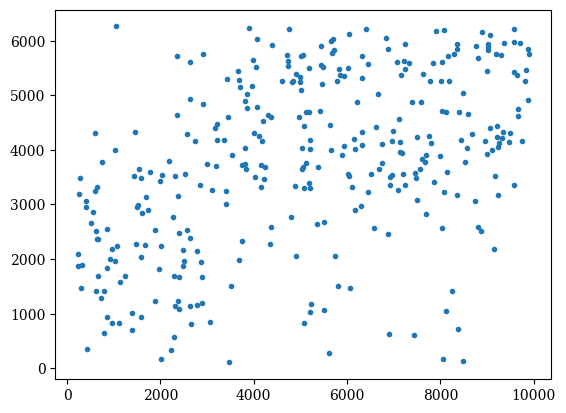

In [45]:
plt.plot(mtbl['X_IMAGE'], mtbl['Y_IMAGE'], '.')

In [54]:
# import numpy as np
from sklearn.linear_model import HuberRegressor
# from sklearn.datasets import make_regression
# 샘플 데이터 생성
X, y = mtbl['bp_rp'].reshape(-1, 1), mtbl['delta_mag'].reshape(-1, 1)
# Huber Regressor 모델 생성
huber = HuberRegressor(epsilon=1.35) # epsilon은 Huber loss에서의 델타 값
huber.fit(X, y)
# 예측값 생성
y_pred = huber.predict(X)
# 예측 결과 출력
print("Predicted values:", y_pred)

Predicted values: [-8.83095471e-03  1.06447152e-03  3.52117204e-03  1.15530982e-02
  2.03836605e-03 -5.34271760e-03  2.59712423e-04 -3.89073952e-03
  3.67985962e-02  4.53322983e-02  1.31783370e-02 -1.62268578e-03
  9.68948662e-03  3.63249816e-03  2.43199245e-02  5.79552516e-03
  5.89475425e-03  1.02148991e-02  3.24299610e-03  8.91921150e-02
 -2.59864293e-03 -5.57533931e-04  6.14817867e-03  4.20791541e-03
  6.15829020e-02  2.68995465e-02  1.07570347e-01  5.08677104e-04
  8.56390537e-03  1.96495790e-02  1.34203425e-03  3.71261533e-04
  1.48633919e-02 -7.20900501e-03  1.72539211e-02  1.81046155e-02
  8.20394905e-03  9.99981802e-05  2.95571580e-02  1.49151248e-02
  4.91305519e-03  2.24535348e-03 -5.00288582e-03 -8.54152832e-05
  9.15658087e-02  6.87794641e-02 -1.62000994e-03  3.37590538e-04
  4.03803205e-02  1.17168819e-02  5.33818857e-04  4.29570436e-02
  1.85549372e-02  1.08138963e-01  2.19268310e-02  3.40789478e-03
 -3.17746073e-03  2.64856923e-03  6.46789054e-02  5.51306138e-02
 -3.361

/Users/paek/opt/miniconda3/envs/sdt/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
huber.get_params()

{'alpha': 0.0001,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 100,
 'tol': 1e-05,
 'warm_start': False}

(-0.2, 0.2)

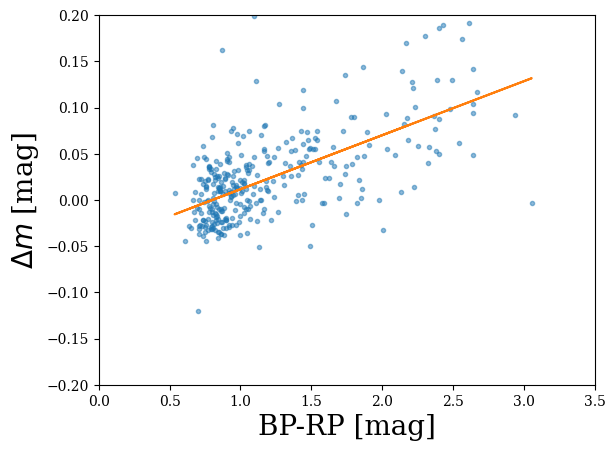

In [61]:
plt.plot(mtbl['bp_rp'], mtbl['delta_mag'], '.', alpha=0.5)
plt.plot(X, y_pred)
plt.xlabel("BP-RP [mag]")
plt.ylabel(r"$\Delta m$ [mag]")
plt.xlim(-0, 3.5)
plt.ylim(-0.2, +0.2)